In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [81]:
def create_lowpass_filter(band_center=0.5, kernelLength=256, transitionBandwidth=0.03):
    # calculate the highest frequency we need to preserve and the
    # lowest frequency we allow to pass through. Note that frequency
    # is on a scale from 0 to 1 where 0 is 0 and 1 is Nyquist 
    # frequency of the signal BEFORE downsampling
    
#     transitionBandwidth = 0.03 
    passbandMax = band_center / (1 + transitionBandwidth)
    stopbandMin = band_center * (1 + transitionBandwidth)
    print(passbandMax)
    print(stopbandMin)
    # Unlike the filter tool we used online yesterday, this tool does
    # not allow us to specify how closely the filter matches our
    # specifications. Instead, we specify the length of the kernel.
    # The longer the kernel is, the more precisely it will match.
#     kernelLength = 256 

    # We specify a list of key frequencies for which we will require 
    # that the filter match a specific output gain.
    # From [0.0 to passbandMax] is the frequency range we want to keep
    # untouched and [stopbandMin, 1.0] is the range we want to remove
    keyFrequencies = [0.0, passbandMax, stopbandMin, 1.0]

    # We specify a list of output gains to correspond to the key
    # frequencies listed above.
    # The first two gains are 1.0 because they correspond to the first
    # two key frequencies. the second two are 0.0 because they 
    # correspond to the stopband frequencies
    gainAtKeyFrequencies = [1.0, 1.0, 0.0, 0.0]

    # This command produces the filter kernel coefficients
    filterKernel = signal.firwin2(kernelLength, keyFrequencies, gainAtKeyFrequencies)    
    
    return filterKernel.astype(np.float32), keyFrequencies, gainAtKeyFrequencies

In [82]:
def downsampling_by_2(x, filterKernel):
    x = conv1d(x,filterKernel,stride=2, padding=(filterKernel.shape[-1]-1)//2)
    return x

In [125]:
lowpass_filter, keyFrequencies, gainAtKeyFrequencies = create_lowpass_filter(band_center = 0.5, kernelLength=256,transitionBandwidth=0.001)

0.4995004995004996
0.5005


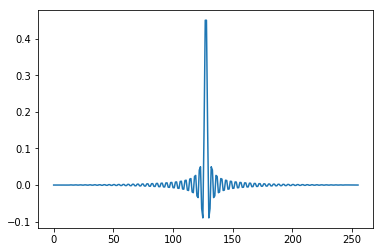

Text(0.5, 1.0, 'Magnitude Response')

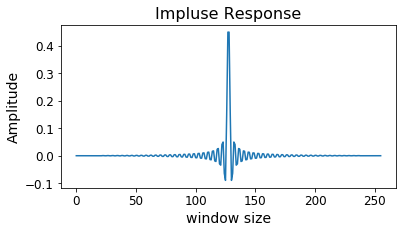

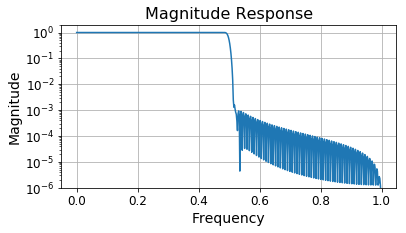

In [168]:
fs=2
fir_firwin2 = signal.firwin2(256, keyFrequencies, gainAtKeyFrequencies)
freq, response = signal.freqz(fir_firwin2)
fig, ax = plt.subplots(1,figsize=(6,3))
ax.plot(lowpass_filter)
ax.tick_params(labelsize=12)
ax.set_ylabel('Amplitude', size=14)
ax.set_xlabel('window size', size=14)
ax.set_title("Impluse Response", size=16)

fig, ax = plt.subplots(1,figsize=(6,3))
ax.semilogy(0.5*fs*freq/np.pi, np.abs(response))
ax.set_ylim(10e-7,2)
ax.grid(True)
ax.tick_params(labelsize=12)
ax.set_ylabel('Magnitude', size=14)
ax.set_xlabel('Frequency', size=14)
ax.set_title("Magnitude Response", size=16)

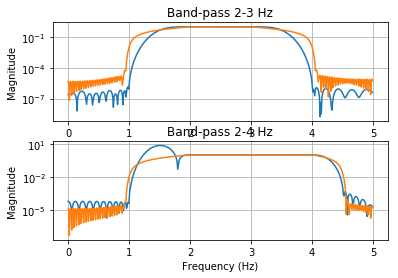

In [77]:
fig, axs = plt.subplots(2)
fs = 10.0  # Hz
desired = (0, 0, 1, 1, 0, 0)
for bi, bands in enumerate(((0, 1, 2, 3, 4, 5), (0, 1, 2, 4, 4.5, 5))):
    fir_firls = signal.firls(73, bands, desired, fs=fs)
    fir_remez = signal.remez(73, bands, desired[::2], fs=fs)
    fir_firwin2 = signal.firwin2(256, bands, desired, fs=fs)
    hs = list()
    ax = axs[bi]
    for fir in (fir_firls, fir_firwin2):
        freq, response = signal.freqz(fir)
        hs.append(ax.semilogy(0.5*fs*freq/np.pi, np.abs(response))[0])
    for band, gains in zip(zip(bands[::2], bands[1::2]),
                           zip(desired[::2], desired[1::2])):
        ax.semilogy(band, np.maximum(gains, 1e-7), 'k--', linewidth=2)
    else:
        ax.set_xlabel('Frequency (Hz)')
    ax.grid(True)
    ax.set(title='Band-pass %d-%d Hz' % bands[2:4], ylabel='Magnitude')